In [53]:
from google.colab import files
import cv2
from skimage import exposure
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [63]:
class Models():
  def __init__(self):
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    self.image = cv2.imread(file_name)


    print("Please Upload Ground Truth")
    uploaded = files.upload()

    # Assuming you know the filename, or if you want to list the uploaded files use: list(uploaded.keys())
    filename = next(iter(uploaded))  # replace with the name of your uploaded file if needed

    # Read the uploaded image file
    self.ground_truth = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    if not (self.image.shape[:2] == self.ground_truth.shape[:2]):
      self.ground_truth = cv2.resize(self.ground_truth, (self.image.shape[1], self.image.shape[0]))

  def Canny(self):
    gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(np.array(normalized_image*255, dtype=np.uint8))

    # Apply Gaussian blur with a larger kernel to smooth the image more
    blurred = cv2.GaussianBlur(equalized_image, (9, 9), 0)

    # Fine-tune the Canny edge thresholds again
    low_threshold = 45  # Lower this if you're missing real edges
    high_threshold = low_threshold * 3  # Keep the upper:lower ratio of about 3:1

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    # Increase the thickness of the edges by dilating the edge image
    kernel = np.ones((4,4), np.uint8)
    brighter_edges = cv2.dilate(edges, kernel, iterations=1)
    return brighter_edges

  def Canny_logical(self):
    brighter_edges = self.Canny()
    r = self.image[:,:,0]>self.image[:,:,0].mean()
    map = brighter_edges>brighter_edges.mean()*1.3
    g = (self.image[:,:,1]>self.image[:,:,1].mean()*0.2)
    l = r | ~g
    fin = ((r & map) & l)
    return fin

  def Soble_fun(self):
    gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(np.array(normalized_image*255, dtype=np.uint8))

    # Experiment with the Gaussian blur to further suppress noise
    blurred_image = cv2.GaussianBlur(equalized_image, (9, 9), sigmaX=2, sigmaY=2)

    # Apply Sobel filters to detect edges
    sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)  # Experiment with the kernel size
    sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the gradient magnitude and normalize
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    sobel_magnitude = np.uint8(sobel_magnitude)

    # Dilate the edges to make them more pronounced
    kernel_dilation = np.ones((2,2), np.uint8)
    dilated_sobel_magnitude = cv2.dilate(sobel_magnitude, kernel_dilation, iterations=1)

    # Apply Otsu's method to find an optimal threshold
    _, otsu_thresh_sobel = cv2.threshold(dilated_sobel_magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological closing followed by opening to clean up the image
    kernel_morph = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    closed_sobel = cv2.morphologyEx(otsu_thresh_sobel, cv2.MORPH_CLOSE, kernel_morph, iterations=2)
    opened_sobel = cv2.morphologyEx(closed_sobel, cv2.MORPH_OPEN, kernel_morph, iterations=1)

    # Find contours and filter based on area size
    contours, _ = cv2.findContours(opened_sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # Filter by area

    # Draw the contours on a black background with white lines
    contour_output = np.zeros_like(opened_sobel)
    cv2.drawContours(contour_output, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Perform max pooling with a 2x2 kernel
    kernel_maxpool = np.ones((4, 4), np.uint8)
    maxpooled_image = cv2.dilate(contour_output, kernel_maxpool)

    mask2 = maxpooled_image > maxpooled_image.mean() * 1.2
    return mask2

  def Hybrid_Canny_Soble(self):
    mask1 = self.Canny()
    mask1 = mask1 > mask1.mean() * 1.2
    mask2 = self.Soble_fun()

    mask3= (mask1 & mask2)

    g = self.image[:,:,1]
    g = g < g.mean()*1.2

    mask5 = mask3 & g

    return mask5

  def Laplacian_fun(self):
    gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(np.array(normalized_image*255, dtype=np.uint8))

    # Experiment with the Gaussian blur to further suppress noise
    blurred_image = cv2.GaussianBlur(equalized_image, (9, 9), sigmaX=2, sigmaY=2)

    # Use a bilateral filter for noise reduction while preserving edges
    bilateral_filtered_image = cv2.bilateralFilter(equalized_image, d=11, sigmaColor=90, sigmaSpace=90)

    # Apply the Laplacian filter using cv2.Laplacian with a larger kernel size
    laplacian = cv2.Laplacian(bilateral_filtered_image, cv2.CV_64F, ksize=5)

    # Convert back to uint8
    laplacian = np.uint8(np.absolute(laplacian))

    mask1 = laplacian > laplacian.mean() * 2
    return mask1

  def Hybrid_Laplacian_Soble(self):
    mask1 = self.Laplacian_fun()
    mask2 = self.Soble_fun()

    mask3= (mask1 & mask2)

    g = self.image[:,:,1]
    g = g < g.mean()*1.2

    mask5 = mask3 & g

    return mask5

  def Hybrid_Laplacian_Canny(self):
    mask1 = self.Laplacian_fun()
    mask2 = self.Canny()


    g = self.image[:,:,1]
    g = g < g.mean()*1.2

    mask3= (mask1 & mask2) & ~g

    return mask3

  def Hough_Transform(self,mask):
    mask = mask.astype(np.uint8)
    contour_output = mask
    # Further increase the threshold and minLineLength, and fine-tune maxLineGap
    lines = cv2.HoughLinesP(contour_output, 1, np.pi / 180, threshold=250, minLineLength=250, maxLineGap=50)

    # Create an image to draw the lines
    line_image = np.zeros_like(contour_output)

    # Draw the lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (255), 1)
    return line_image

  def Decision_Metrics(self,op_put_image):

    #plt.imshow(ground_truth,cmap='gray')
    if op_put_image.max() != True:

      line_image = (op_put_image>op_put_image.mean())
    else:
      line_image = op_put_image

    binary_image = np.array(line_image) * 255

    # Convert to 8-bit unsigned integer
    binary_image = binary_image.astype(np.uint8)


    # Create a grayscale image
    line_gray_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)



    if len(line_gray_image.shape) == 3:
        line_gray_image = cv2.cvtColor(line_gray_image, cv2.COLOR_BGR2GRAY)

    # Resize the ground truth to match the Hough Transform output
    # This step is crucial to compare the images using SSIM
    ground_truth = cv2.resize(self.ground_truth, (line_gray_image.shape[1], line_image.shape[0]))


    similarity_index, diff = ssim(self.ground_truth, line_image, full=True)

    binarized_ground_truth = (self.ground_truth > self.ground_truth.mean())

    # Flatten the binary images to 1D arrays for comparison
    binarized_ground_truth_flat = binarized_ground_truth.flatten()
    binarized_line_image_flat = line_image.flatten()


    ## Calculate precision, recall, F1 score, and accuracy
    precision = precision_score(binarized_ground_truth_flat, binarized_line_image_flat)
    recall = recall_score(binarized_ground_truth_flat, binarized_line_image_flat)
    f1 = f1_score(binarized_ground_truth_flat, binarized_line_image_flat)
    accuracy = accuracy_score(binarized_ground_truth_flat, binarized_line_image_flat)

    ## Print out the metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print(f'SSIM: {similarity_index}')


model = Models()

Saving L97c_img1.jpg to L97c_img1 (1).jpg
Please Upload Ground Truth


Saving image1_groundtruth.jpeg to image1_groundtruth (4).jpeg


Model:Soble_fun


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.2217
Recall: 0.6312
F1 Score: 0.3281
SSIM: 0.6829212602087533


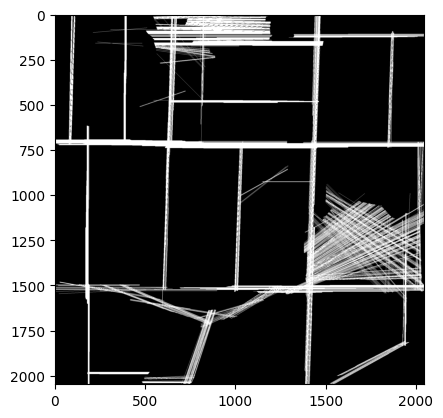

In [64]:
print("Model:Soble_fun")
op1 = model.Soble_fun()
ht = model.Hough_Transform(op1)
model.Decision_Metrics(ht)
plt.imshow(ht,cmap='gray')

Model:Canny


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.2236
Recall: 0.2482
F1 Score: 0.2353
SSIM: 0.6666089975620694


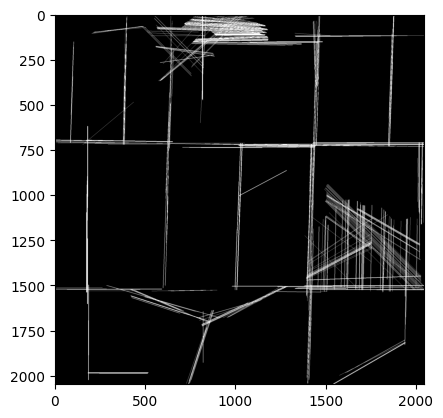

In [65]:
print("Model:Canny")
op1 = model.Canny()
ht = model.Hough_Transform(op1)
model.Decision_Metrics(ht)
plt.imshow(ht,cmap='gray')

Model:Laplacian_fun


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.1836
Recall: 0.5792
F1 Score: 0.2788
SSIM: 0.6887262323272643


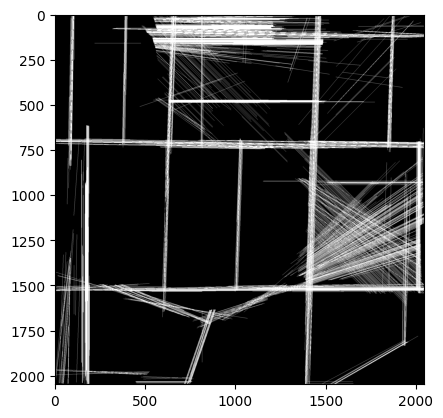

In [66]:
print("Model:Laplacian_fun")
op1 = model.Laplacian_fun()
ht = model.Hough_Transform(op1)
model.Decision_Metrics(ht)
plt.imshow(ht,cmap='gray')

Model:Hybrid_Canny_Soble


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.2199
Recall: 0.2125
F1 Score: 0.2161
SSIM: 0.6650731132248104


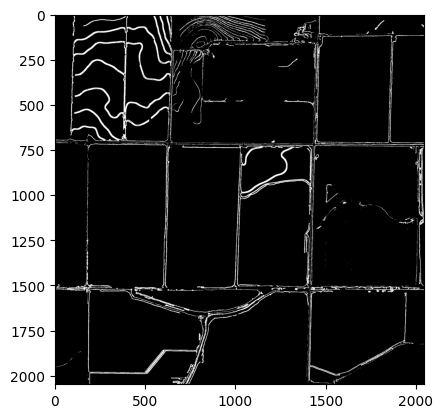

In [67]:
print("Model:Hybrid_Canny_Soble")
op1 = model.Hybrid_Canny_Soble()
model.Decision_Metrics(op1)
plt.imshow(op1,cmap='gray')

Model:Hybrid_Laplacian_Soble


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.2390
Recall: 0.2775
F1 Score: 0.2568
SSIM: 0.6669429047170844


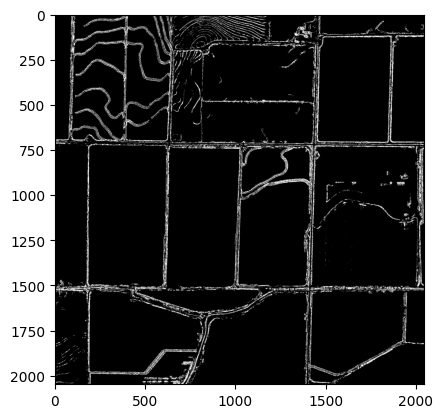

In [68]:
print("Model:Hybrid_Laplacian_Soble")
op1 = model.Hybrid_Laplacian_Soble()
model.Decision_Metrics(op1)

plt.imshow(op1,cmap='gray')

Model:Hybrid_Laplacian_Canny
Precision: 0.2015
Recall: 0.1000
F1 Score: 0.1337
SSIM: 0.6605029925433233


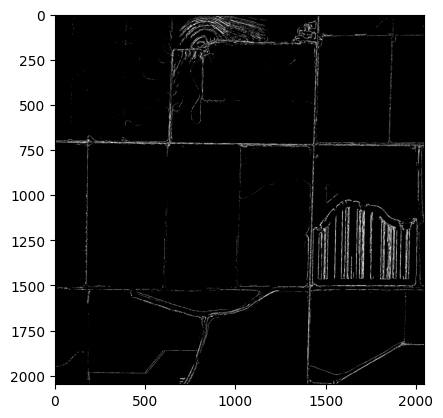

In [69]:
print("Model:Hybrid_Laplacian_Canny")
op1 = model.Hybrid_Laplacian_Canny()
model.Decision_Metrics(op1)

plt.imshow(op1,cmap='gray')

Model:Canny_logical


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.2033
Recall: 0.2541
F1 Score: 0.2259
SSIM: 0.668074203208697


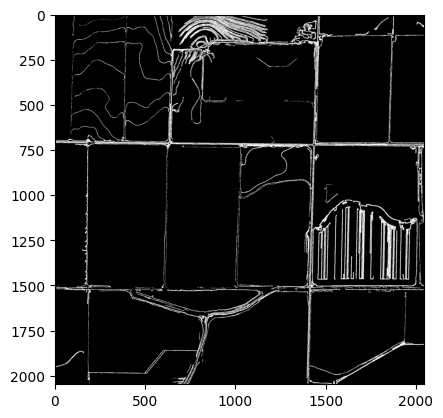

In [70]:
print("Model:Canny_logical")
op1 = model.Canny_logical()
model.Decision_Metrics(op1)

plt.imshow(op1,cmap='gray')